In [1]:
import re
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import seaborn as sns
import xarray as xr
from salishsea_tools import geo_tools, geo_tools, tidetools
import functools
from IPython.display import clear_output
import datetime


%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [2]:
station_lon_lat = pd.read_pickle("/ocean/jpetrie/MEOPAR/analysis-james/station_location.pkl")

In [3]:
# Grab plankton data from excel file
plank_df_list = []
for i in range(1,4):
    df = pd.read_excel('/ocean/shared/SoG/PHYTO/Profiles_by_station.xls',i)
    top_index = pd.Index(df["Vol"]).get_loc("Species")
    bottom_index = pd.Index(df["Vol"]).get_loc("Carbon (ng/l)")
    df = pd.concat([df.iloc[:top_index], df.iloc[(bottom_index + 1):]])
    df = df.transpose()
    df.columns = df.iloc[0]
    df.drop(df.index[0], inplace=True)
    df.reset_index(inplace = True)
    plank_df_list.append(df)

In [4]:
# convert plankton dataframe data types

all_plank = pd.concat(plank_df_list,  axis=0, ignore_index=True)

all_plank.loc[all_plank["Date"] == "14/15-Apr-04", "Date"] = "2004-04-14 00:00:00"

all_plank["STATION"] = "S" + all_plank["Site"].astype(str).str.strip()
all_plank["DATE"] = pd.to_datetime(all_plank["Date"], format='%Y-%m-%d', errors = "coerce")
all_plank["DATE_STR"] = [d.strftime('%Y-%m-%d') if not pd.isnull(d) else np.nan for d in all_plank['DATE']] 
all_plank["MONTH"] = all_plank["DATE"].apply(lambda x: x.month)
all_plank["DAY_OF_MONTH"] = all_plank["DATE"].apply(lambda x: x.day)
all_plank["DEPTH"] = pd.to_numeric(all_plank["Depth (m)"], errors = "coerce")
all_plank["DIATOMS(ngC/L)"] = pd.to_numeric(all_plank["Total diatoms"], errors = "coerce")

# Convert from nanogram carbon per litre to millimol Nitrogen per metre^3
# 10^-9 for nanogram Carbon -> gram Carbon
# 0.083259 for gram carbon -> mol Carbon
# 16/106 for mol carbon -> mol nitrogen
# 10^3 for mol nitrogen -> mmol nitrogen
# 1/(1/10^3) for 1/L -> 1/m^3
all_plank["DIATOMS(mmolN/m3)"] = all_plank["DIATOMS(ngC/L)"]*(10**-9)*(0.083259)*(16.0/106)*(10**3)*(10**3)

In [12]:
# Choose which values to add to nowcast dataframe

tracers = ["PHY2", "PHY", "MICZ", "MYRI"]

plot_months = ["mar", "apr"]

plot_hours = np.array([0, 12, 18])

max_depth = 20
result_depths = xr.open_dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/deptht_428m.nc').deptht.values
depth_indices = np.where(result_depths < max_depth)[0]

model_points = station_lon_lat["MODEL_POINT"]
model_js = [x[0] for x in model_points] 
model_is = [x[1] for x in model_points] 

stations = station_lon_lat["STATION"]

In [ ]:
# Iterate through nowcast green results, grabbing certain tracers, locations, and dates/times
# Create pandas dataframe and save result

load_new_dataset = True

if load_new_dataset:
    nowcast_dir = "/results/SalishSea/nowcast-green/" #"/data/jpetrie/MEOPAR/SalishSea/results/nowcast_results/"

    month_num = {"jan": "01","feb": "02", "mar": "03", "apr": "04", "may": "05", "jun": "06", "jul": "07", "aug": "08", "sep": "09", "oct": "10", "nov": "11", "dec": "12" }

    mixed_format_dates = os.listdir(nowcast_dir)
    number_format_dates = ["20" + x[5:7] + month_num[x[2:5]] + x[0:2] for x in mixed_format_dates]
    sorted_dirs = [mixed_format_date for (number_format_date, mixed_format_date) in sorted(zip(number_format_dates,mixed_format_dates))]
    
    
    dataframe_list = []
    num_files = 0
    start_time = datetime.datetime.now()
    for subdir in sorted_dirs:
        if os.path.isdir(nowcast_dir + '/' + subdir) and re.match("[0-9]{2}[a-z]{3}[0-9]{2}", subdir):
            month_str = subdir[2:5]
            date_str = "20" + subdir[5:7] + month_num[month_str] + subdir[0:2]
            tracer_file = "SalishSea_1h_" + date_str + "_" + date_str + "_ptrc_T.nc"
            tracer_path = nowcast_dir + "/" + subdir + "/" + tracer_file
            if os.path.isfile(tracer_path) and month_str in plot_months:
                grid_t = xr.open_dataset(tracer_path)
                result_hours = pd.DatetimeIndex(grid_t.time_centered.values).hour
                time_indices = np.where([(x in plot_hours) for x in result_hours])
                
                J, T, Z = np.meshgrid(model_js,time_indices,depth_indices, indexing = 'ij')
                I, T, Z = np.meshgrid(model_is,time_indices,depth_indices, indexing = 'ij')
                
                tracer_dataframes = []
                for t in tracers:
                    station_slice = grid_t[t].values[T,Z,J,I]
                    slice_xarray = xr.DataArray(station_slice,
                                     [stations,result_hours[time_indices], result_depths[depth_indices]],
                                     ["STATION", "HOUR", "DEPTH"], 
                                     t)
                    slice_dataframe = slice_xarray.to_dataframe()
                    slice_dataframe.reset_index(inplace = True)
                    tracer_dataframes.append(slice_dataframe)
                merged_tracers = functools.reduce(lambda left,right: pd.merge(left,right,on=["STATION", "HOUR", "DEPTH"]), tracer_dataframes)
                merged_tracers["DATE"] =  pd.to_datetime(date_str, infer_datetime_format=True)
                merged_tracers["MONTH"] = int(month_num[month_str])
                dataframe_list.append(merged_tracers)

                num_files = num_files + 1
                run_time = datetime.datetime.now() - start_time
                clear_output()
                print("Files loaded:" + str(num_files))
                print("Date of most recent nowcast load: " + date_str)
                print("Time loading: ")
                print(run_time)
                print("\n\n\n")
                print(merged_tracers)

    nowcast_df = pd.concat(dataframe_list)    
    t = datetime.datetime.now()
    time_string = str(t.year) +"_"+ str(t.month) +"_"+ str(t.day) +"_"+ str(t.hour) +"_"+ str(t.minute)
    nowcast_df.to_pickle("/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/"+ time_string + ".pkl") 
    
else: 
    past_dataset_path = "/ocean/jpetrie/MEOPAR/analysis-james/nowcast_green_subset/2016_8_3_16_58.pkl"
    nowcast_df = pd.read_pickle(past_dataset_path)

Files loaded:4
Date of most recent nowcast load: 20160304
Time loading: 
0:01:12.664789




     STATION  HOUR      DEPTH      PHY2       PHY      MICZ      MYRI  \
0       S2-3     0   0.500000  3.582503  0.528760  0.030515  0.086204   
1       S2-3     0   1.500003  3.687060  0.545156  0.031156  0.088228   
2       S2-3     0   2.500011  3.662790  0.545769  0.031042  0.087400   
3       S2-3     0   3.500031  3.509039  0.556055  0.031310  0.084113   
4       S2-3     0   4.500071  3.227916  0.542984  0.030945  0.076259   
5       S2-3     0   5.500151  2.961458  0.512883  0.030059  0.067904   
6       S2-3     0   6.500310  2.765032  0.484699  0.029181  0.062102   
7       S2-3     0   7.500623  2.599420  0.461057  0.028534  0.058543   
8       S2-3     0   8.501236  2.354736  0.425326  0.027561  0.052952   
9       S2-3     0   9.502433  2.011805  0.376650  0.026298  0.044964   
10      S2-3     0  10.504766  1.822211  0.351750  0.025618  0.041338   
11      S2-3     0  11.509312  1

In [31]:
nowcast_df["DAY_OF_MONTH"] = nowcast_df["DATE"].apply(lambda x: x.day)

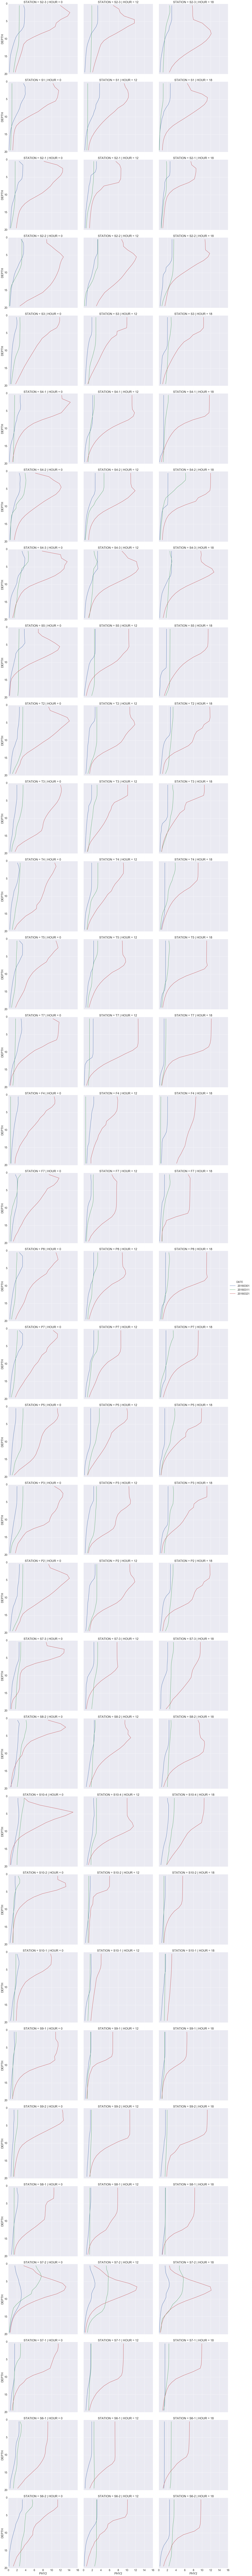

In [8]:
sns.set(font_scale = 2)
fg = sns.FacetGrid(data = nowcast_df[(pd.to_numeric(nowcast_df["DAY_OF_MONTH"])).isin([1,11,21])], hue = "DATE",col = "HOUR", row = "STATION", size =8)
fg.map(plt.plot, "PHY2", "DEPTH").add_legend()
plt.gca().invert_yaxis()

In [76]:
diatom_df = all_plank[["DATE", "DEPTH", "STATION", "MONTH", "DAY_OF_MONTH", "DIATOMS(mmolN/m3)"]]
diatom_df["DATA_TYPE"] = "Measured Diatoms"

def dateToString(date):
    try:
        date_string = date.strftime('%Y-%m-%d')
    except:
        date_string = "NULL"
    return(date_string)

nowcast_df["DATA_TYPE"] = "Simulated PHY2"
nowcast_df["DIATOMS(mmolN/m3)"] = nowcast_df["PHY2"]
combined = pd.concat([diatom_df, nowcast_df.query("HOUR == 12")], ignore_index=True)
combined["IDENTIFIER"] = combined["DATA_TYPE"] + ", Date = " + combined["DATE"].apply(dateToString)
#combined = combined.sort_values(["DATA_TYPE", "DAY_OF_MONTH", "IDENTIFIER"])

/home/jpetrie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


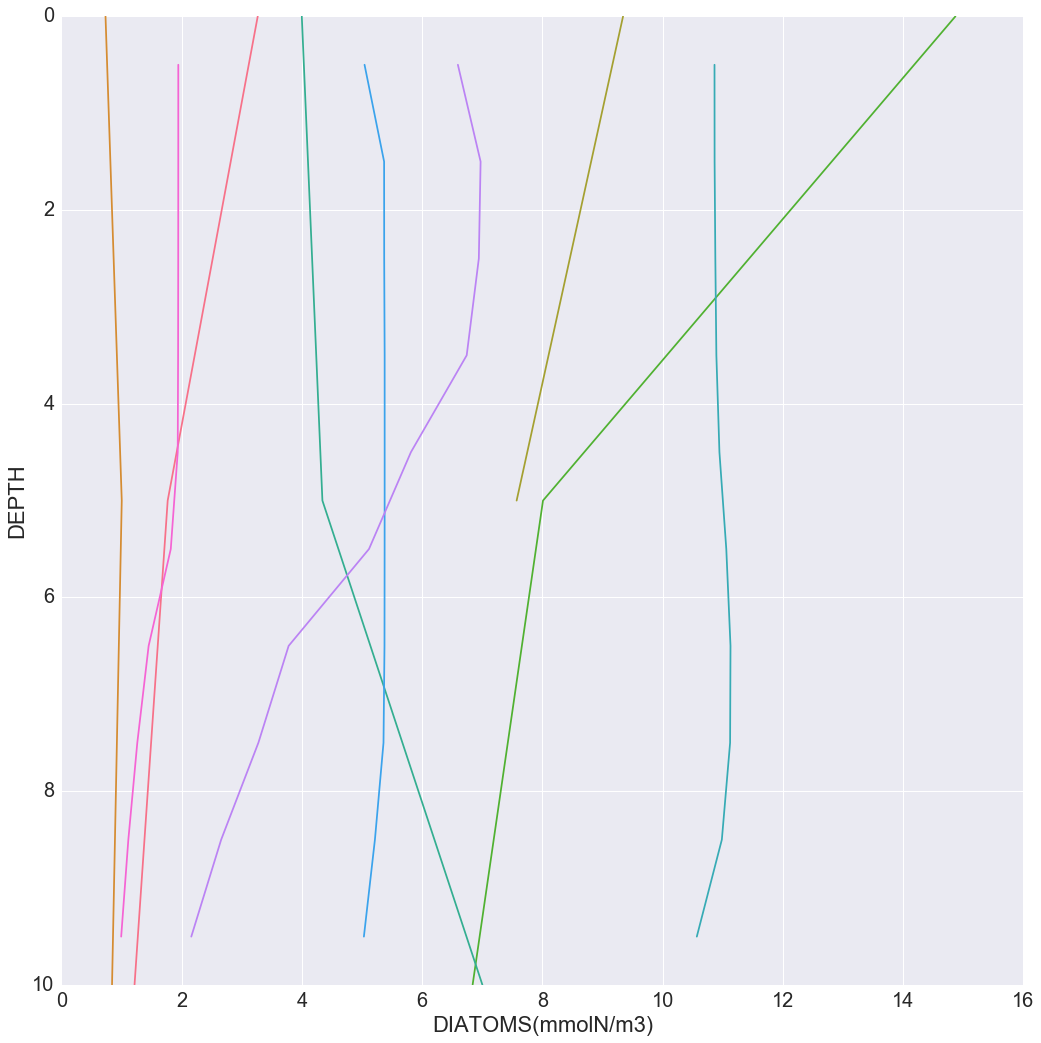

In [77]:
# S3 is the only station with multiple depth measurements on the same day for total diatoms
# March and April are the only months with significant diatom population measured at S3

combined_subset = combined.query("STATION == 'S3' & MONTH == @month & DEPTH <= 10 & (DATA_TYPE == 'Measured Diatoms' | DAY_OF_MONTH%8 == 1)")

plt.rcParams['image.cmap'] = 'jet'

markers = ['>','o', 'v', '8', 's', '<', 'p', '*', 'h', '^', 'H', 'D', 'd']
num_lines = len(np.unique(combined_subset["IDENTIFIER"]))
markers = markers*(num_lines//len(markers)) + markers[:(num_lines%len(markers))]


sns.set(font_scale = 2)
fg = sns.FacetGrid(data = combined_subset, size =15, hue = "IDENTIFIER")

fg.map(plt.plot, "DIATOMS(mmolN/m3)", "DEPTH")
#fg.map(sns.pointplot, "DIATOMS(mmolN/m3)", "DEPTH")
plt.gca().invert_yaxis()

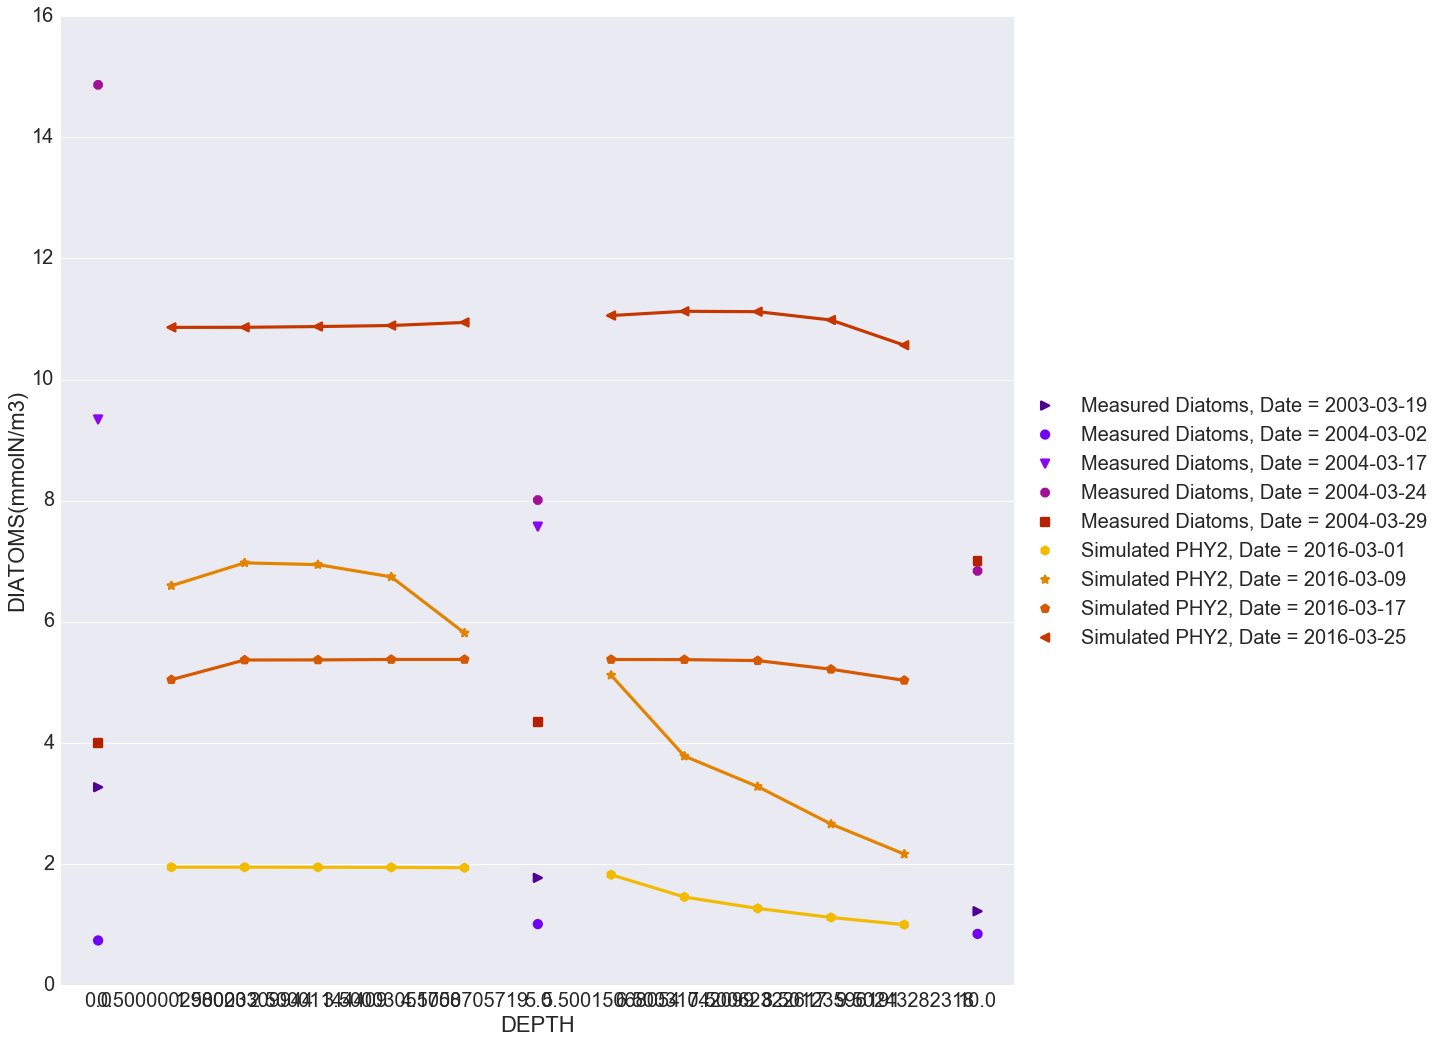

In [78]:
combined_subset.sort_values(["IDENTIFIER"])
fg = sns.FacetGrid(data=combined_subset, size =15)
fg.map(sns.pointplot, "DEPTH", "DIATOMS(mmolN/m3)", "IDENTIFIER",  markers = markers,palette="gnuplot")
fg.add_legend()


In [69]:
combined_subset

,DATA_TYPE,DATE,DAY_OF_MONTH,DEPTH,DIATOMS(mmolN/m3),HOUR,MONTH,PHY2,STATION,IDENTIFIER
50,Measured Diatoms,2004-03-02,2.0,0.000000,0.732879,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-02"
51,Measured Diatoms,2004-03-02,2.0,5.000000,1.002894,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-02"
52,Measured Diatoms,2004-03-02,2.0,10.000000,0.841290,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-02"
53,Measured Diatoms,2004-03-17,17.0,0.000000,9.340202,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-17"
54,Measured Diatoms,2004-03-17,17.0,5.000000,7.570174,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-17"
34,Measured Diatoms,2003-03-19,19.0,0.000000,3.264421,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2003-03-19"
35,Measured Diatoms,2003-03-19,19.0,5.000000,1.766885,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2003-03-19"
36,Measured Diatoms,2003-03-19,19.0,10.000000,1.215396,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2003-03-19"
55,Measured Diatoms,2004-03-24,24.0,0.000000,14.867989,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-24"
56,Measured Diatoms,2004-03-24,24.0,5.000000,8.008639,NaN,3.0,NaN,S3,"Measured Diatoms, Date = 2004-03-24"


In [10]:
all_plank.columns

Index([                              'index',
                                    'Counts',
                                    'Cruise',
                                      'Date',
                                      'Site',
                                 'Depth (m)',
                'Asterionellopsis glacialis',
                    'Chaetoceros atlanticus',
                    'Chaetoceros convolutus',
                    'Chaetoceros curvisetus',
                     'Chaetoceros decipiens',
                   'Chaetoceros lasciniosus',
                      'Chaetoceros radicans',
                      'Chaetoceros socialis',
                          'Chaetoceros spp.',
                      'Corethron criophilum',
                  'Cylindrotheca closterium',
                      'Ditylum brightwellii',
                           'Haslea wrarikae',
                      'Guinardia delicatula',
                             'Gyrosigma sp.',
                    'Leptocylindru